In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
from itertools import combinations

IMG_PATH = "_img"
CACHE_PATH = "../fitting/_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
import joblib

from astroML.utils.decorators import pickle_results

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as  mpatches
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.io import load_libraries
from MaStarChecks.preprocessing import build_train_test
from MaStarChecks.plotting.analysis import build_comparison_table
from MaStarChecks.plotting.styles import *

PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.2")
CLASSIFIED_PATH = "../fitting/_data/classified-mastar-v3.1.2-cleaned-v2-gsl"

LABELS = ("GSL", "MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r""]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$"], units.values())}

In [2]:
# TODO: use the spectral energy distributions in physical units to improve the logg estimation

spectra, catalogues = load_libraries(labels=LABELS, libraries_path=PROCESSED_PATH, use_cache=True, cache_path=CACHE_PATH)

catalogue = pd.DataFrame()
for label, c in catalogues.items():
    c["LIBRARY"] = label
    catalogue = catalogue.append(c, ignore_index=True)

catalogue.rename(columns=cols, inplace=True)
spectra = pd.concat([s["FLUX"] for label, s in spectra.items()], axis="index", ignore_index=True)

# spectra.loc[catalogue.LIBRARY=="MaStar"].sample(n=10, random_state=123).T.plot(lw=1)

catalogue[cols.get("TEFF")] = np.log10(catalogue[cols.get("TEFF")])

y = catalogue.filter(items=list(cols.values()))
# masking stars with weird alpha abundances
y = y.mask((catalogue.LIBRARY=="MaStar")&(y[cols.get("ALPHAM")]<=-0.1))

training_set, testing_set, labelled_set = build_train_test(labels=y, test_ratio=0.10, random_state=123, verbose=True)

X_train = spectra.loc[training_set]
y_train = y.loc[training_set]

X_test = spectra.loc[testing_set]
y_test = y.loc[testing_set]

X_labelled = spectra.loc[labelled_set]
y_labelled = y.loc[labelled_set]

training_set_gsl = training_set[catalogue.loc[training_set].LIBRARY=="GSL"]
training_set_y19 = training_set[catalogue.loc[training_set].LIBRARY=="MaStar"]
testing_set_gsl = testing_set[catalogue.loc[testing_set].LIBRARY=="GSL"]
testing_set_y19 = testing_set[catalogue.loc[testing_set].LIBRARY=="MaStar"]

labelled set : 32796
training set : 29516
testing set  : 3280


In [3]:
pickle_filename = "../busy-week/_cache/estimator-mor-v3.1.2-cleaned-v2-gsl.pk"
mor = joblib.load(pickle_filename)

In [8]:
from astropy.io import fits
from astropy.table import Table


CATALOGUE_MASTAR_PATH = "_data/mastar-catalogue-v3.1.2-cleaned-v2-gsl.fits.gz"
REWRITE = True

if REWRITE or not os.path.isfile(CATALOGUE_MASTAR_PATH):
    catalogue_mastar, spectra_mastar = catalogue.loc[catalogue.LIBRARY=="MaStar"], spectra.loc[catalogue.LIBRARY=="MaStar"]
    catalogue_mastar = catalogue_mastar.rename(columns={v:k for k, v in cols.items()})
    catalogue_mastar = catalogue_mastar.drop(columns="BIBREF NAMES PHOTCAT BMAG VMAG SPTYPE GOODSP GOODPH GOODRV LIBRARY".split())
    catalogue_mastar[list(cols.keys())] = pd.DataFrame(index=spectra_mastar.index, columns=cols.keys(), data=mor["mode"].predict(spectra_mastar))
    catalogue_mastar.TEFF = 10**catalogue_mastar.TEFF
    # y_p16 = pd.DataFrame(index=spectra_mastar.index, columns=cols.keys(), data=mor["P16"].predict(spectra_mastar))
    # y_p84 = pd.DataFrame(index=spectra_mastar.index, columns=cols.keys(), data=mor["P84"].predict(spectra_mastar))

    wl = spectra.columns
    delt = np.diff(wl)[0]
    if not np.all(np.diff(wl)==delt):
        print("ERROR: the wavelength sampling is not uniform")

    spectra_hdr = fits.Header([
        ("CRVAL1", wl[0]),
        ("CDELT1", delt),
        ("CRPIX1", 1),
        ("CTYPE1", "wavelength"),
        ("CUNIT1", "AA")
    ])
    spectra_hdu = fits.PrimaryHDU(data=spectra_mastar.values, header=spectra_hdr)
    spectra_hdu.name = "SPECTRA"
    spectra_hdu.header
    # np.all(wl==((np.arange(spectra_hdu.header["NAXIS1"])+1)-spectra_hdu.header["CRPIX1"])*spectra_hdu.header["CDELT1"]+spectra_hdu.header["CRVAL1"])

    fmts = {column: "E" if catalogue_mastar.dtypes[column]!="object" else f"A{catalogue_mastar[column].apply(lambda s: len(s)).max()}" for column in catalogue_mastar.columns}
    units = dict([
        ("ID", ""),
        ("RECORD", ""),
        ("NEXP", ""),
        ("SCI", ""),
        ("RA", "HH:MM:SS.ss"),
        ("DEC", "DD:MM:SS.ss"),
        ("DIST", "kpc"),
        ("EBV", "mag"),
        ("VCORR", ""),
        ("SNR", ""),
        ("FNORM", "erg/s/cm^2/AA"),
        ("USDSS", "mag"),
        ("GSDSS", "mag"),
        ("RSDSS", "mag"),
        ("ISDSS", "mag"),
        ("ZSDSS", "mag"),
        ("RADVEL", "km/s"),
        ("RVERR", "km/s"),
        ("TEFF", "K"),
        ("LOGG", "log/cm/s^2"),
        ("MET", "[Fe/H]"),
        ("ALPHAM", "[alpha/M]")
    ])
    columns = []
    for column in catalogue_mastar.columns:
        columns.append(fits.Column(name=column, array=catalogue_mastar[column].values, format=fmts[column], unit=units[column]))

    table_hdu = fits.BinTableHDU.from_columns(columns)
    table_hdu.name = "CATALOGUE"
    hdus = fits.HDUList([spectra_hdu,table_hdu])
    hdus.info()
    hdus.writeto(CATALOGUE_MASTAR_PATH, overwrite=True)

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPECTRA       1 PrimaryHDU      12   (6351, 20332)   float64   
  1  CATALOGUE     1 BinTableHDU     69   20332R x 22C   ['22A', 'E', 'E', 'E', '12A', '13A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   


In [ ]:
y_model = pd.DataFrame(index=y_test.index, columns=y_test.columns, data=mor["mode"].predict(X_test.fillna(0)))
y_model[cols.get("TEFF")] = 10**y_model[cols.get("TEFF")]
y_test[cols.get("TEFF")] = 10**y_test[cols.get("TEFF")]

model_eval = pd.merge(y_model.add_suffix(" model"), y_test.add_suffix(" true"), left_index=True, right_index=True, how="inner")
# model_eval = model_eval.loc[y_test[cols.get("LOGG")]<=3.5]
residuals = model_eval.filter(like="model").rename(columns=lambda s: s.replace(" model",""))-model_eval.filter(like="true").rename(columns=lambda s: s.replace(" true",""))
residuals = residuals.add_prefix("$\Delta$")
model_eval = pd.concat((model_eval,residuals), axis="columns")
model_eval["library"] = catalogue.loc[testing_set].LIBRARY.replace({"MaStar":"MaStarDR1"})

In [ ]:
model_eval.groupby("library").agg(["mean", "std"])

$T_\mathrm{eff}$~(K) model              $\log{g}$ model            \
                                mean          std            mean       std   
library                                                                       
GSL                      5666.782371  1709.513444        3.239043  1.700684   
MaStarDR1                4870.084265   769.632019        2.985130  1.108183   

          $[\mathrm{Fe}/\mathrm{H}]$ model            \
                                      mean       std   
library                                                
GSL                              -1.273680  1.127241   
MaStarDR1                        -0.647902  0.752207   

          $[\alpha/\mathrm{Fe}]$ model           $T_\mathrm{eff}$~(K) true  \
                                  mean       std                      mean   
library                                                                      
GSL                           0.418514  0.439184               5667.643865   
MaStarDR1                     0.153126  0.132615               4877.992883   

                        ... $[\alpha/\mathrm{Fe}]$ true            \
                   std  ...                        mean       std   
library                 ...                                         
GSL        1709.993983  ...                    0.417228  0.455706   
MaStarDR1   797.441788  ...                    0.145116  0.136501   

          $\Delta$$T_\mathrm{eff}$~(K)             $\Delta$$\log{g}$  \
                                  mean         std              mean   
library                                                                
GSL                          -0.861495   46.651022         -0.001456   
MaStarDR1                    -7.908617  227.865262          0.033636   

                    $\Delta$$[\mathrm{Fe}/\mathrm{H}]$            \
                std                               mean       std   
library                                                            
GSL        0.213826                           0.001203  0.161697   
MaStarDR1  0.454887                          -0.011468  0.303176   

          $\Delta$$[\alpha/\mathrm{Fe}]$            
                                    mean       std  
library                                             
GSL                             0.001287  0.086364  
MaStarDR1                       0.008010  0.130387  

[2 rows x 24 columns]

$T_\mathrm{eff}$~(K) model              $\log{g}$ model            \
                                mean          std            mean       std   
library                                                                       
GSL                      5666.782371  1709.513444        3.239043  1.700684   
MaStarDR1                4870.084265   769.632019        2.985130  1.108183   

          $[\mathrm{Fe}/\mathrm{H}]$ model            \
                                      mean       std   
library                                                
GSL                              -1.273680  1.127241   
MaStarDR1                        -0.647902  0.752207   

          $[\alpha/\mathrm{Fe}]$ model           $T_\mathrm{eff}$~(K) true  \
                                  mean       std                      mean   
library                                                                      
GSL                           0.418514  0.439184               5667.643865   
MaStarDR1                     0.153126  0.132615               4877.992883   

                        ... $[\alpha/\mathrm{Fe}]$ true            \
                   std  ...                        mean       std   
library                 ...                                         
GSL        1709.993983  ...                    0.417228  0.455706   
MaStarDR1   797.441788  ...                    0.145116  0.136501   

          $\Delta$$T_\mathrm{eff}$~(K)             $\Delta$$\log{g}$  \
                                  mean         std              mean   
library                                                                         
GSL                          -0.861495   46.651022         -0.001456   
MaStarDR1                    -7.908617  227.865262          0.033636   

          $\Delta$$[\mathrm{Fe}/\mathrm{H}]$            \
                                        mean       std   
library                                                  
GSL        0.213826                           0.001203  0.161697   
MaStarDR1  0.454887                          -0.011468  0.303176   

          $\Delta$$[\alpha/\mathrm{Fe}]$            
                                    mean       std  
library                                             
GSL                             0.001287  0.086364  
MaStarDR1                       0.008010  0.130387  

[2 rows x 24 columns]

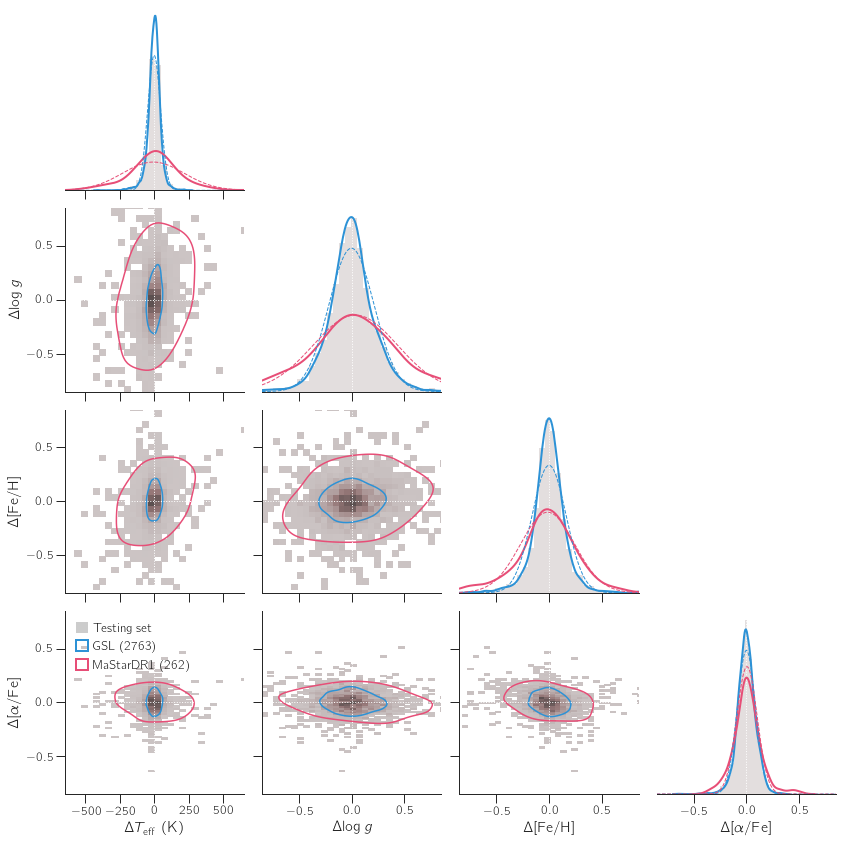

In [ ]:
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*(x - mu)**2/sigma**2)

limits = dict(zip(residuals.columns, [(-650,650)] + 3*[(-0.85,+0.85)]))
ticks = dict(zip(residuals.columns, [250] + 3*[0.5]))

g = sns.pairplot(residuals, kind="hist", corner=True, height=3,
                 plot_kws={"color":LIGHT_COLOR, "bins":70, "stat":"density", "pthresh":0.0},
                 diag_kws={"lw":0, "fc":LIGHT_COLOR, "bins":70, "stat":"density", "pthresh":0.0},
                 grid_kws={"diag_sharey":False}
)
g.map_diag(lambda x, color, label: plt.axvline(ls=":", lw=1, color="w"))
g.map_lower(lambda x, y, color: plt.axvline(ls=":", lw=1, color="w"))
g.map_lower(lambda x, y, color: plt.axhline(ls=":", lw=1, color="w"))

for (i, column), ax in zip(enumerate(residuals.columns), g.diag_axes):
    mu_m20 = np.mean(residuals.loc[model_eval.library=="GSL",column])
    mu_y19 = np.mean(residuals.loc[model_eval.library=="MaStarDR1",column])
    mu_y19_test = mu_y19 - mu_m20
    
    sigma_m20 = np.std(residuals.loc[model_eval.library=="GSL",column])
    sigma_y19 = np.std(residuals.loc[model_eval.library=="MaStarDR1",column])
    sigma_y19_test = np.sqrt(np.abs(sigma_y19**2 - sigma_m20**2))
    
    print(column)
    print(np.mean(residuals[column]), np.std(residuals[column]))
#     print(mu_m20, sigma_m20, mu_y19_test, sigma_y19_test)
    
    sns.kdeplot(x=residuals.loc[model_eval.library=="GSL",column], color=GSL_COLOR, lw=2, ax=ax, clip=limits[column])
    sns.kdeplot(x=residuals.loc[model_eval.library=="MaStarDR1",column], color=Y19_COLOR, lw=2, ax=ax, clip=limits[column])
    
    support = np.linspace(*limits[column], 1000)
    ax.plot(support, gaussian(support, mu=mu_m20, sigma=sigma_m20), "--", color=GSL_COLOR, lw=1)
#     ax.plot(support, gaussian(support, mu=mu_y19, sigma=sigma_y19), ":", color=Y19_COLOR, lw=1)
    ax.plot(support, gaussian(support, mu=mu_y19_test, sigma=sigma_y19_test), "--", color=Y19_COLOR, lw=1)
    
    g.diag_axes[i].set_xlim(*limits[column])
    g.diag_axes[i].xaxis.set_major_locator(ticker.MultipleLocator(ticks[column]))
for (column_x,column_y), (j,i) in zip(combinations(residuals.columns, 2), (combinations([0,1,2,3], 2))):
    sns.kdeplot(x=residuals.loc[model_eval.library=="GSL",column_x], y=residuals.loc[model_eval.library=="GSL",column_y], levels=(0.32,), color=GSL_COLOR,
                linewidths=1.5, ax=g.axes[i,j])
    sns.kdeplot(x=residuals.loc[model_eval.library=="MaStarDR1",column_x], y=residuals.loc[model_eval.library=="MaStarDR1",column_y], levels=(0.32,), color=Y19_COLOR,
                linewidths=1.5, ax=g.axes[i,j])
    
    g.axes[i,j].set_xlim(*limits[column_x])
    g.axes[i,j].set_ylim(*limits[column_y])
    g.axes[i,j].xaxis.set_major_locator(ticker.MultipleLocator(ticks[column_x]))
    g.axes[i,j].yaxis.set_major_locator(ticker.MultipleLocator(ticks[column_y]))

handles = [mpatches.Patch(facecolor="0.8", label="Testing set"),
           mpatches.Patch(facecolor="none", edgecolor=GSL_COLOR, lw=2, label="GSL ({})".format((model_eval.library=="GSL").sum())),
           mpatches.Patch(facecolor="none", edgecolor=Y19_COLOR, lw=2, label="MaStarDR1 ({})".format((model_eval.library=="MaStarDR1").sum()))]
legend = g.axes[3,0].legend(handles=handles, loc=2)
g.fig.savefig("_img/consistency-testing.png", bbox_inches="tight")

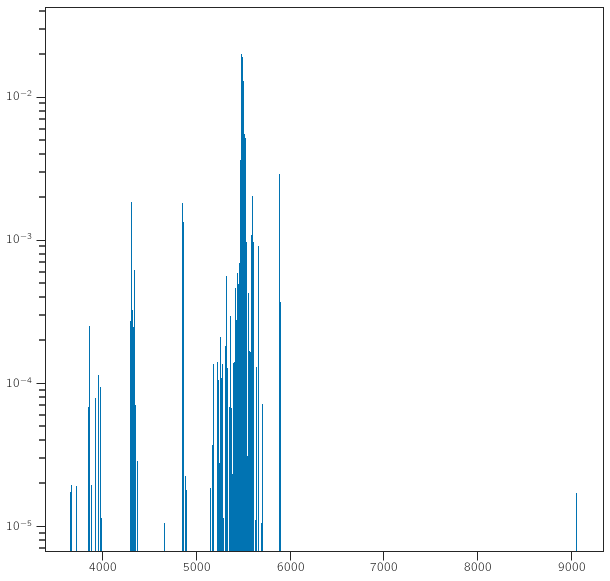

In [8]:
from scipy.ndimage import gaussian_filter1d


feature_importance = gaussian_filter1d(mor["mode"].estimators_[3].feature_importances_, sigma=5, truncate=6, mode="constant")

plt.bar(X_test.columns[feature_importance>1e-5], feature_importance[feature_importance>1e-5])
plt.gca().set_yscale("log")